## MIMIC database tables types:

| Patient tracking | ICU data | Hospital data | Dimension tables |
| --- | --- | --- | --- |
| admissions | chartevents | caregivers | d_cpt |
| icustays | inputevents_cv | cptevents | d_icd_procedures |
| patients | inputevents_mv | diagnoses_icd | d_items |
| callout | datetimeevents | drgcodes | d_icd_diagnoses |
| transfers | outputevents | labevents | d_labitems |
|  | procedureevents_mv | microbiologyevents | |
|  |  | noteevents | |
|  |  | prescriptions | |
|  |  | procedures_icd | |
|  |  | services | |


In [1]:
import os
import re
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer 
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

## 1. Data preparation and exploratory analysis

In [2]:
# database directory list
db_dir = os.getcwd() + "\mimic-iii-clinical-database-demo-1.4"
db_container = os.listdir(db_dir)



# database tables selection
db_tables = []

for f in db_container:
    if f.endswith('.csv'):
        db_tables.append(f)
db_tables

['ADMISSIONS.csv',
 'CALLOUT.csv',
 'CAREGIVERS.csv',
 'CHARTEVENTS.csv',
 'CPTEVENTS.csv',
 'DATETIMEEVENTS.csv',
 'DIAGNOSES_ICD.csv',
 'DRGCODES.csv',
 'D_CPT.csv',
 'D_ICD_DIAGNOSES.csv',
 'D_ICD_PROCEDURES.csv',
 'D_ITEMS.csv',
 'D_LABITEMS.csv',
 'ICUSTAYS.csv',
 'INPUTEVENTS_CV.csv',
 'INPUTEVENTS_MV.csv',
 'LABEVENTS.csv',
 'MICROBIOLOGYEVENTS.csv',
 'NOTEEVENTS.csv',
 'OUTPUTEVENTS.csv',
 'PATIENTS.csv',
 'PRESCRIPTIONS.csv',
 'PROCEDUREEVENTS_MV.csv',
 'PROCEDURES_ICD.csv',
 'SERVICES.csv',
 'TRANSFERS.csv']

In [3]:
to_read = ['ADMISSIONS.csv', 'CALLOUT.csv', 'DRGCODES.csv', 'ICUSTAYS.csv', 'PATIENTS.csv', 'PRESCRIPTIONS.csv']

In [4]:
i = 1
for tab in to_read:
    
    tname = tab.rsplit('.', 1)[0]
    print(f"Reading " + tab + " ...")
    df = pd.read_csv('./mimic-iii-clinical-database-demo-1.4/' + tab, error_bad_lines=False, low_memory=False)
    # Dataframe names on fly assignment
    globals()[tname] = df
    i += 1

Reading ADMISSIONS.csv ...
Reading CALLOUT.csv ...
Reading DRGCODES.csv ...
Reading ICUSTAYS.csv ...
Reading PATIENTS.csv ...
Reading PRESCRIPTIONS.csv ...


In [5]:
# Dataframes columns subsets preview

In [6]:
ADM = ADMISSIONS[['subject_id', 'hadm_id', 'deathtime', 'discharge_location', 'hospital_expire_flag']]
# discharge_location variable is strictly related to the hospital_expire_flag

# Investigation of whether a given patient died in hospital
df1 = ADM.drop(['hadm_id', 'deathtime', 'discharge_location'], axis = 1).groupby('subject_id').sum()
df1[df1 > 0] = 1
df1 = df1.reset_index()
df1

,subject_id,hospital_expire_flag
0,10006,0
1,10011,1
2,10013,1
3,10017,0
4,10019,1
...,...,...
95,44083,0
96,44154,1
97,44212,0
98,44222,0


Text(0.5, 1.08, 'Response variable values counts')

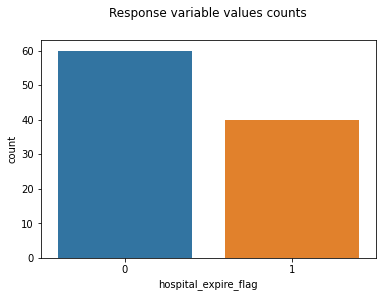

In [7]:
g = sns.countplot(df1['hospital_expire_flag'])
g.set_title("Response variable values counts", y=1.08)

As response variable in unbalanced **confusion matrix** and **F1 score** will be used as classification performance measurement.

In [8]:
# Investigating whether a given patient has ever needed e.g. a ventilator
CAL = CALLOUT[['subject_id', 'hadm_id', 'request_tele', 'request_resp', 'request_cdiff', 'request_mrsa', 'request_vre']]
df2 = CAL.drop(['hadm_id'], axis = 1).groupby('subject_id').sum()
df2[df2 > 0] = 1
df2 = df2.reset_index()
df2

,subject_id,request_tele,request_resp,request_cdiff,request_mrsa,request_vre
0,10017,1,0,0,0,0
1,10026,1,0,0,0,0
2,10027,1,0,0,0,0
3,10029,0,0,0,1,1
4,10033,1,0,0,0,0
5,10038,0,0,0,0,0
6,10059,1,0,0,0,0
7,10065,1,0,0,1,0
8,10083,0,0,0,0,0
9,10090,1,0,0,0,0


In [9]:
ICUS = ICUSTAYS[['subject_id', 'hadm_id', 'first_careunit', 'last_careunit', 'first_wardid', 'last_wardid', 'los']]
# calculation of the sum of the lengths of stays for each patient
df3 = ICUS.groupby('subject_id').agg(sum = pd.NamedAgg(column='los', aggfunc=sum)).reset_index()
df3 = df3.rename(columns = {'sum': 'aggr_los'})

df3

,subject_id,aggr_los
0,10006,1.6325
1,10011,13.8507
2,10013,2.6499
3,10017,2.1436
4,10019,1.2938
...,...,...
95,44083,7.6487
96,44154,0.6259
97,44212,31.1235
98,44222,1.3279


<AxesSubplot:xlabel='aggr_los', ylabel='Density'>

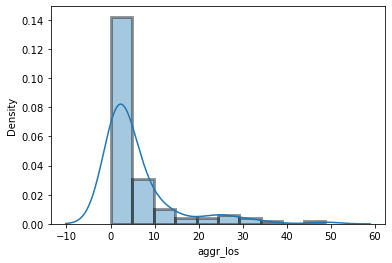

In [10]:
sns.distplot(df3['aggr_los'], bins=10, hist_kws={'edgecolor': 'black', 'linewidth': 3})

In [11]:
print(f'Skewness: %f' % df3['aggr_los'].skew())

Skewness: 2.610121


Text(0.5, 1.0, 'Sums of lengths of stays boxplot')

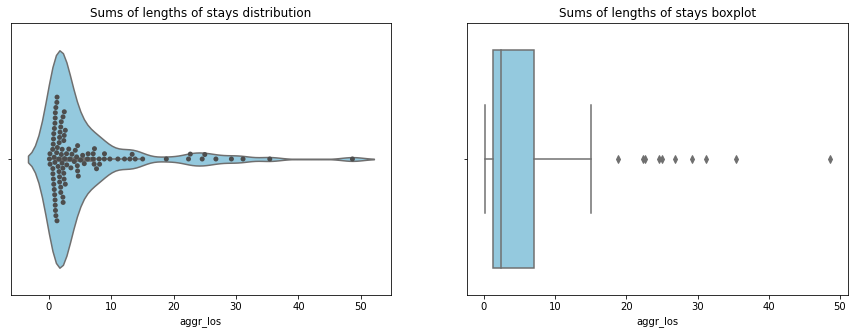

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.violinplot(df3['aggr_los'], ax = ax[0], bw = 0.2, color="skyblue").set_title("Sums of lengths of stays distribution")
sns.swarmplot(df3['aggr_los'], ax = ax[0], color=".3")

sns.boxplot(df3['aggr_los'], ax = ax[1], color="skyblue").set_title("Sums of lengths of stays boxplot")

In [13]:
ICUS_2 = ICUSTAYS[['subject_id', 'hadm_id', 'first_careunit', 'last_careunit',  'los', 'intime', 'outtime']]
ICUS_2

,subject_id,hadm_id,first_careunit,last_careunit,los,intime,outtime
0,10006,142345,MICU,MICU,1.6325,2164-10-23 21:10:15,2164-10-25 12:21:07
1,10011,105331,MICU,MICU,13.8507,2126-08-14 22:34:00,2126-08-28 18:59:00
2,10013,165520,MICU,MICU,2.6499,2125-10-04 23:38:00,2125-10-07 15:13:52
3,10017,199207,CCU,CCU,2.1436,2149-05-29 18:52:29,2149-05-31 22:19:17
4,10019,177759,MICU,MICU,1.2938,2163-05-14 20:43:56,2163-05-16 03:47:04
...,...,...,...,...,...,...,...
131,44083,198330,CCU,CCU,3.6174,2112-05-29 02:01:33,2112-06-01 16:50:40
132,44154,174245,MICU,MICU,0.6259,2178-05-14 20:29:55,2178-05-15 11:31:12
133,44212,163189,MICU,MICU,31.1235,2123-11-24 14:14:29,2123-12-25 17:12:19
134,44222,192189,CCU,CCU,1.3279,2180-07-19 06:56:38,2180-07-20 14:48:45


In [14]:
df6 = ICUS_2.groupby('subject_id', as_index=False).agg({'intime': 'min'}).merge(ICUS_2, on=['subject_id', 'intime'], how='left')[['subject_id', 'first_careunit']]
df7 = ICUS_2.groupby('subject_id', as_index=False).agg({'outtime': 'max'}).merge(ICUS_2, on=['subject_id', 'outtime'], how='left')[['subject_id', 'last_careunit']]
                                                                                                                                  
df6.columns=['subject_id', 'first_ever_careunit']
df7.columns=['subject_id', 'last_ever_careunit']

<AxesSubplot:>

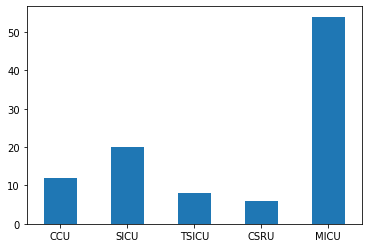

In [15]:
df6['first_ever_careunit'].value_counts(sort=False).plot.bar(rot=0)

<AxesSubplot:>

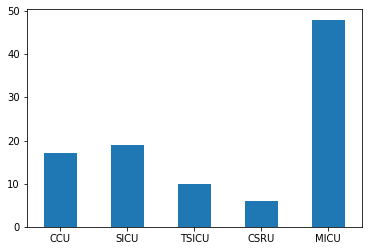

In [16]:
df7['last_ever_careunit'].value_counts(sort=False).plot.bar(rot=0)

In [17]:
# checking what types of drugs and in what amounts were taken by individual patients
PRESC = PRESCRIPTIONS[['subject_id', 'hadm_id', 'drug_type']].drop_duplicates().reset_index(drop = True)
df4 = PRESC.drop(['hadm_id'], axis = 1)
df4 = pd.get_dummies(df4).groupby('subject_id').sum().reset_index()
df4

,subject_id,drug_type_ADDITIVE,drug_type_BASE,drug_type_MAIN
0,10006,0,1,1
1,10013,0,1,1
2,10017,0,1,1
3,10019,1,1,1
4,10026,0,1,1
...,...,...,...,...
89,44083,1,3,3
90,44154,0,1,1
91,44212,0,1,1
92,44222,0,1,1


In [18]:
#etchnicity 
df5 = ADMISSIONS[['subject_id', 'ethnicity']]
df5 = df5.drop_duplicates()
any(df5[['subject_id']].duplicated()) #check if any patient declared more than one ethnicity

False

<AxesSubplot:>

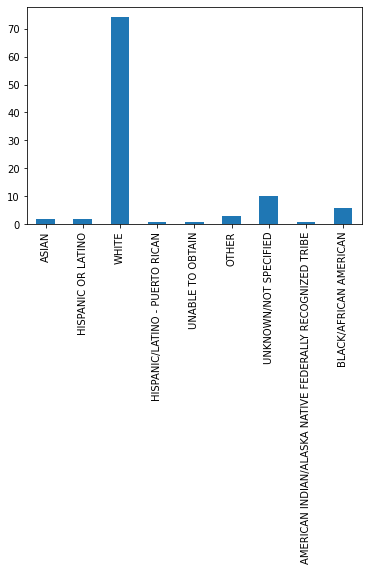

In [19]:
df5 = df5.reset_index(drop=True)
df5['ethnicity'].value_counts(sort=False).plot.bar(rot=90)

In [20]:
enc = OneHotEncoder(handle_unknown='ignore')
enc_df = pd.DataFrame(enc.fit_transform(df5[['ethnicity']]).toarray())
enc_df.columns=enc.get_feature_names(['ethnicity'])
df5 = pd.concat([df5, enc_df ], axis=1)

df5

,subject_id,ethnicity,ethnicity_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE,ethnicity_ASIAN,ethnicity_BLACK/AFRICAN AMERICAN,ethnicity_HISPANIC OR LATINO,ethnicity_HISPANIC/LATINO - PUERTO RICAN,ethnicity_OTHER,ethnicity_UNABLE TO OBTAIN,ethnicity_UNKNOWN/NOT SPECIFIED,ethnicity_WHITE
0,10006,BLACK/AFRICAN AMERICAN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10011,UNKNOWN/NOT SPECIFIED,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,10013,UNKNOWN/NOT SPECIFIED,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,10017,WHITE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,10019,WHITE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
95,44083,WHITE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
96,44154,WHITE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
97,44212,BLACK/AFRICAN AMERICAN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
98,44222,WHITE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [21]:
df5 = df5.drop(['ethnicity'], axis=1) #encoded ethnicity

In [22]:
PAT = PATIENTS[['subject_id', 'dod_hosp', 'dod_ssn', 'expire_flag']]

# The trial database only contains data on deceased patients
PAT['expire_flag'].values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [23]:
# Data frame creation

In [24]:
dataFrame = df1.merge(df3, on = 'subject_id', how = 'left')
dataFrame = dataFrame.merge(df4, on = 'subject_id', how = 'left')
dataFrame = dataFrame.merge(df2, on = 'subject_id', how = 'left')
dataFrame = dataFrame.merge(df5, on ='subject_id', how='left')
dataFrame = dataFrame.merge(df6, on ='subject_id', how='left')
dataFrame = dataFrame.merge(df7, on ='subject_id', how='left')

In [25]:
dataFrame

,subject_id,hospital_expire_flag,aggr_los,drug_type_ADDITIVE,drug_type_BASE,drug_type_MAIN,request_tele,request_resp,request_cdiff,request_mrsa,...,ethnicity_ASIAN,ethnicity_BLACK/AFRICAN AMERICAN,ethnicity_HISPANIC OR LATINO,ethnicity_HISPANIC/LATINO - PUERTO RICAN,ethnicity_OTHER,ethnicity_UNABLE TO OBTAIN,ethnicity_UNKNOWN/NOT SPECIFIED,ethnicity_WHITE,first_ever_careunit,last_ever_careunit
0,10006,0,1.6325,0.0,1.0,1.0,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MICU,MICU
1,10011,1,13.8507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,MICU,MICU
2,10013,1,2.6499,0.0,1.0,1.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,MICU,MICU
3,10017,0,2.1436,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,CCU,CCU
4,10019,1,1.2938,1.0,1.0,1.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,MICU,MICU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,44083,0,7.6487,1.0,3.0,3.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,SICU,CCU
96,44154,1,0.6259,0.0,1.0,1.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,MICU,MICU
97,44212,0,31.1235,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MICU,MICU
98,44222,0,1.3279,0.0,1.0,1.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,CCU,CCU


In [26]:
# replace NaNs with zeros
dataFrame = dataFrame.replace(np.nan,0)

In [27]:
dataFrame['first_ever_careunit'] = dataFrame['first_ever_careunit'].astype(np.object) #proba zrobienia na factory - zobaczymy czy pojdzie model jak nie to one hot

In [28]:
dataFrame['last_ever_careunit'] = dataFrame['last_ever_careunit'].astype(np.object)

In [29]:
# first_ever_careunit & last_ever_careunit variables label encoding
from sklearn import preprocessing
le1 = preprocessing.LabelEncoder()
le2 = preprocessing.LabelEncoder()
dataFrame['first_ever_careunit'] = le1.fit_transform(dataFrame['first_ever_careunit'])
dataFrame['first_ever_careunit'] = dataFrame['first_ever_careunit'].astype(np.object)
dataFrame['last_ever_careunit'] = le2.fit_transform(dataFrame['last_ever_careunit'])
dataFrame['last_ever_careunit'] = dataFrame['last_ever_careunit'].astype(np.object)

Text(0.5, 1.08, 'Continuous variable (aggr_los) distribution with respect to response variable value')

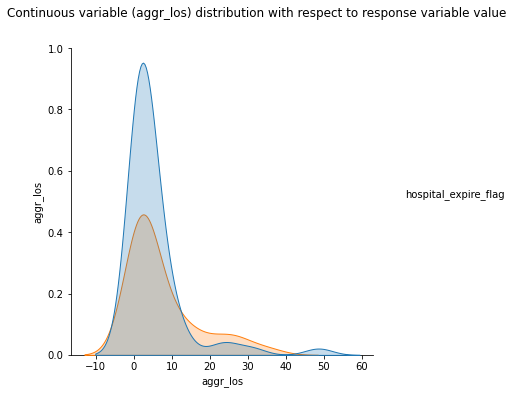

In [30]:
g = sns.pairplot(dataFrame[["aggr_los", "hospital_expire_flag"]], hue="hospital_expire_flag", plot_kws=dict(alpha=0.6), size = 5)
g.fig.suptitle("Continuous variable (aggr_los) distribution with respect to response variable value", y=1.08)

## 2. Model evaluation & hyperparameters tuning

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [32]:
X = dataFrame.drop(['hospital_expire_flag'], axis = 1)
y = dataFrame['hospital_expire_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [35]:
# Base model to tune creation
rf = RandomForestClassifier()

# Grid search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
random_grid = {'bootstrap': [True, False],
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [130, 180, 230]}

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, scoring = 'f1', n_iter = 500, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   57.2s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  2.1min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=500,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [130, 180, 230]},
                   random_state=42, scoring='f1', verbose=2)

In [36]:
# Cross-validation results
pd.DataFrame(rf_random.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.575413,0.011207,0.040333,0.004064,180,5,1,auto,None,True,"{'n_estimators': 180, 'min_samples_split': 5, ...",0.285714,0.166667,0.133333,0.195238,0.065408,2
1,0.565275,0.019303,0.044610,0.002160,180,5,4,auto,70,True,"{'n_estimators': 180, 'min_samples_split': 5, ...",0.000000,0.000000,0.000000,0.000000,0.000000,351
2,0.406954,0.020742,0.039337,0.000394,180,10,2,sqrt,20,False,"{'n_estimators': 180, 'min_samples_split': 10,...",0.307692,0.000000,0.142857,0.150183,0.125722,31
3,0.321055,0.005135,0.032377,0.002056,130,5,1,auto,80,False,"{'n_estimators': 130, 'min_samples_split': 5, ...",0.250000,0.000000,0.133333,0.127778,0.102138,181
4,0.308733,0.009229,0.033425,0.001847,130,10,4,auto,100,False,"{'n_estimators': 130, 'min_samples_split': 10,...",0.153846,0.000000,0.000000,0.051282,0.072524,329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.604607,0.004764,0.053522,0.003104,230,5,2,sqrt,40,False,"{'n_estimators': 230, 'min_samples_split': 5, ...",0.266667,0.000000,0.142857,0.136508,0.108959,97
496,0.478793,0.007650,0.040450,0.002313,130,5,1,sqrt,None,True,"{'n_estimators': 130, 'min_samples_split': 5, ...",0.266667,0.166667,0.142857,0.192063,0.053640,3
497,0.458554,0.006805,0.035141,0.001820,130,5,1,sqrt,70,True,"{'n_estimators': 130, 'min_samples_split': 5, ...",0.250000,0.000000,0.142857,0.130952,0.102409,150
498,0.475386,0.010266,0.049312,0.004230,180,2,1,auto,100,False,"{'n_estimators': 180, 'min_samples_split': 2, ...",0.222222,0.000000,0.133333,0.118519,0.091325,244


In [37]:
# Most accurate parameters
rf_random.best_params_

{'n_estimators': 130,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 90,
 'bootstrap': True}

In [38]:
# F1 score for the most accurate model
rf_random.best_score_

0.21693121693121695

In [39]:
clf = rf_random.best_estimator_

In [81]:
# Artificial synthesis of more observations 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

cv = StratifiedKFold(n_splits=10, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []
    
for (train, test), i in zip(cv.split(X_train, y_train), range(5)):
    clf.fit(X_train.iloc[train], y_train.iloc[train])

In [82]:
y_pred = clf.predict(X_test)
y_pred

array([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0], dtype=int64)

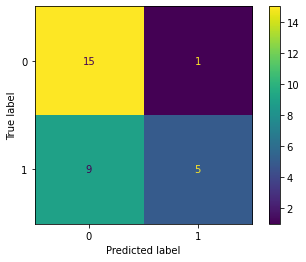

In [83]:
# Confusion matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_test, y_test) 

In [84]:
# F1 scores for each class
from sklearn.metrics import f1_score

f1_score(y_true = y_test, y_pred = y_pred, average=None)

array([0.75, 0.5 ])